# Notebook 1: Ecuaciones clásicas de Euler: Simulación datos entrenamiento

## 1. Introducción
En este notebook resolveremos las ecuaciones clásicas de Euler para el problema Sod Shock tube. Usaremos la librería 
<a href="https://www.clawpack.org/pyclaw/">PyClaw</a>. El sistema de ecuaciones diferenciales es escrito como:

$$
(1)\:\:\frac{\partial\rho}{\partial t}+\frac{\partial j}{\partial x}=0,
$$

$$
(2)\:\:\frac{\partial j}{\partial t}+\frac{\partial\left(p+\frac{1}{\rho}j^{2}\right)}{\partial x}=0,
$$

$$
(3)\:\:\frac{\partial e}{\partial t}+\frac{\partial\left[\frac{1}{\rho}j\left(e+p\right)\right]}{\partial x}=0,
$$

donde $\rho$ es la densidad del fluido, $p$ es la presión, $j=\rho u$ el momento de densidad y $e$ la densidad de energía total (energía total por unidad de volumen). Entonces, nuestro conjunto de variables estará formado por $\textbf{U}=(\rho,j,e)$. Además, la ecuación de estado que relaciona la presión y el resto de variables es:

$$
(4)\:\:p=(\gamma-1)\left(e-\frac{1}{2}\frac{j^{2}}{\rho}\right),
$$

Donde $\gamma=1.4$ se define como el coeficiente de dilatación adiabática. El dominio espacio-temporal del sistema para ser calcualdo será:

$$
t\in[0,0.2]\:\:\:\text{and}\:\:\:x\in[0,1].
$$

Las condiciones iniciales para el Sod Tube Problem son:

$$ \text{Condiciones iniciales ($t=0$)}=  \left\{
\begin{array}{ll}
      \rho_{0}:\:\rho=1.0 & \text{si $x\leq 0.5$ y $\rho=0.125$ si no}\\
      u_{0}:\:u=0 & \forall x\\
      j_{0}:\:j=0 & \forall x\\
      p_{0}:\:p=1.0 & \text{si $x\leq 0.5$ y $p=0.1$ si no}\\
      e_{0}:\:e=\frac{1}{\gamma-1} & \text{si $x\leq 0.5$ y $e=\frac{0.1}{\gamma-1}$ si no} \\
\end{array} 
\right. $$

Respecto las condiciones de contorno, este problema se construirá usando condiciones de contorno Dirichlet,  es decir, para las cantidades conservadas ($\rho$, $j$ y $e$) los valores en la frontera espacial serán constantes e iguales a las condiciones iniciales.

$$
\rho(t,0)=1.0,\:\:\rho(t,1)=0.125
$$

$$
u(t,0)=u(t,1)=0
$$

$$
j(t,0)=j(t,1)=0
$$

$$
p(t,0)=1.0,\:\:p(t,1)=0.1
$$

$$
e(t,0)=\frac{1}{\gamma-1},\:\:e(t,1)=\frac{0.1}{\gamma-1}
$$

Consideraremos $nx=8192$ puntos para la rejilla de $x$, y un escalón temporal de $\Delta t=0.00005$, lo que resulta en $nt=4000$.

## 2. Set up
### 2.1. Librerías

In [1]:
# Error logging
import logging

# Numeric wrangling
import numpy as np

# Data plotting
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# Time execution
import time

# Data saving
import h5py

<frozen importlib._bootstrap>:228: RuntimeWarning: mpi4py.MPI.Status size changed, may indicate binary incompatibility. Expected 40 from C header, got 48 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: mpi4py.MPI.Datatype size changed, may indicate binary incompatibility. Expected 24 from C header, got 32 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: mpi4py.MPI.Request size changed, may indicate binary incompatibility. Expected 32 from C header, got 40 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: mpi4py.MPI.Prequest size changed, may indicate binary incompatibility. Expected 32 from C header, got 40 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: mpi4py.MPI.Grequest size changed, may indicate binary incompatibility. Expected 40 from C header, got 48 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: mpi4py.MPI.Message size changed, may indicate binary incompatibility. Expected 32 from C header, got 4

In [2]:
# Numerical solution calculation
from __future__ import absolute_import
from clawpack import riemann
from clawpack.riemann.euler_with_efix_1D_constants import density, momentum, energy, num_eqn
from clawpack import pyclaw


### 2.2. Settings

In [3]:
logger = logging.getLogger('pyclaw')
logger.setLevel(logging.CRITICAL)

In [4]:
solver_type='classic'
kernel_language='Python'

if kernel_language =='Python':
    rs = riemann.euler_1D_py.euler_hllc_1D
elif kernel_language =='Fortran':
    rs = riemann.euler_hlle_1D
    
if solver_type=='sharpclaw':
    solver = pyclaw.SharpClawSolver1D(rs)
elif solver_type=='classic':
    solver = pyclaw.ClawSolver1D(rs)
    
solver.kernel_language = kernel_language

### 2.3. Constantes

In [5]:
# Ratio of specific heats
gamma = 1.4

## 3. Simulación

In [6]:
# Set the boundary conditions
solver.bc_lower[0]=pyclaw.BC.extrap
solver.bc_upper[0]=pyclaw.BC.extrap

# Define equations and variables to be simulated
mx = 8192
x = pyclaw.Dimension(0.,1.0,mx,name='x')
domain = pyclaw.Domain([x])
state = pyclaw.State(domain,num_eqn)

state.problem_data['gamma'] = gamma
state.problem_data['gamma1'] = gamma - 1.

x = state.grid.x.centers

rho_l = 1.; rho_r = 1./8
p_l = 1.; p_r = 0.1
state.q[density ,:] = (x<0.5)*rho_l + (x>=0.5)*rho_r
state.q[momentum,:] = 0.
velocity = state.q[momentum,:]/state.q[density,:]
pressure = (x<0.5)*p_l + (x>=0.5)*p_r
state.q[energy  ,:] = pressure/(gamma - 1.) + 0.5 * state.q[density,:] * velocity**2

In [7]:
claw = pyclaw.Controller()
claw.tfinal = 0.2
claw.solution = pyclaw.Solution(state,domain)
claw.solver = solver
claw.num_output_times = 4000
claw.output_format = None
claw.keep_copy = True

In [8]:
start = time.time()
status = claw.run()
end = time.time()
print(f'Tiempo de ejecución: {end-start}s')

Tiempo de ejecución: 24.010016679763794s


## 4. Visualización

Podemos obtener la visualización para un instante temporal dado. Para $t=0$:

In [9]:
frame = claw.frames[0]
#print(frame.q.shape)
rho = frame.q[0,:]
j = frame.q[1,:]
e = frame.q[2,:]

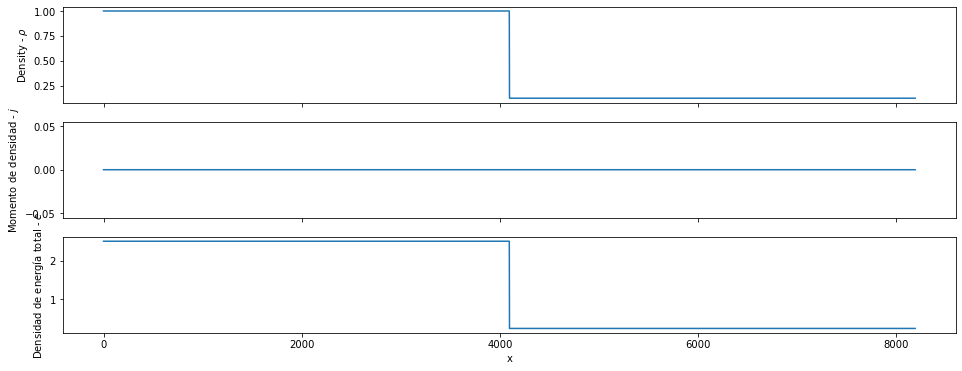

In [10]:
fig, ax = plt.subplots(3, figsize=(16, 9/1.5), sharex=True)

#fig.suptitle(r'PyClaw simulation $t=0$', size=20)

ax[0].plot(rho)
ax[0].set_ylabel(r"Density - $\rho$")

ax[1].plot(j)
ax[1].set_ylabel(r"Momento de densidad - $j$")

ax[2].plot(e)
ax[2].set_ylabel(r"Densidad de energía total - $e$")
ax[2].set_xlabel('x')

plt.savefig("figs/tube1.png")
plt.show()

Visualizamos para el momento final $t=0.2$

In [11]:
frame = claw.frames[len(claw.frames)-1]
#print(frame.q.shape)
rho = frame.q[0,:]
j = frame.q[1,:]
e = frame.q[2,:]

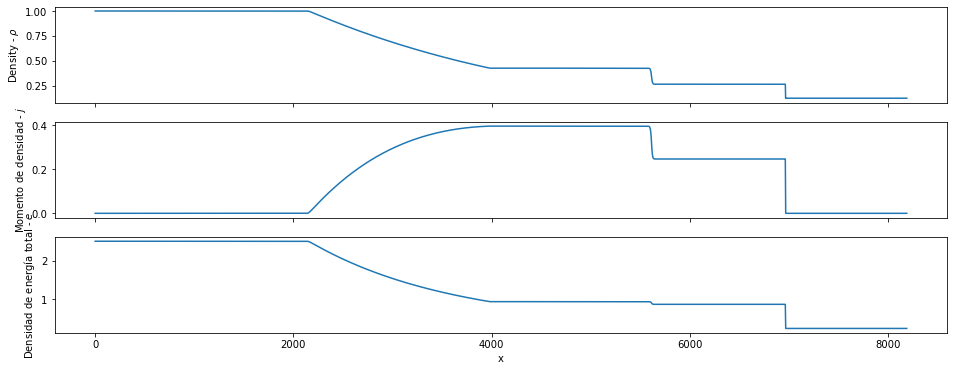

In [12]:
fig, ax = plt.subplots(3, figsize=(16, 9/1.5), sharex=True)

#fig.suptitle(r'PyClaw simulation $t=0.2$', size=20)

ax[0].plot(rho)
ax[0].set_ylabel(r"Density - $\rho$")

ax[1].plot(j)
ax[1].set_ylabel(r"Momento de densidad - $j$")

ax[2].plot(e)
ax[2].set_ylabel(r"Densidad de energía total - $e$")
ax[2].set_xlabel('x')

plt.savefig("figs/tube2.png")
plt.show()

O podemos visualizar las variables para todo el dominio temporal:

In [13]:
frames = claw.frames

times = np.linspace(0, 0.2, 4001)

rho_evolved = []
j_evolved = []
e_evolved = []

for frame in frames:
    rho_evolved.append(frame.q[0,:])
    j_evolved.append(frame.q[1,:])
    e_evolved.append(frame.q[2,:])

rho_evolved = np.array(rho_evolved) # Shape (nt, nx)
j_evolved = np.array(j_evolved) # Shape (nt, nx)
e_evolved = np.array(e_evolved) # Shape (nt, nx)

x = np.linspace(0, 1, 8192)
X, T = np.meshgrid(x, times)

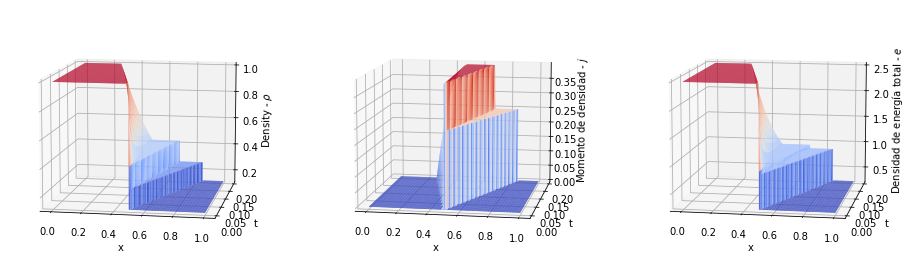

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(16, 9/1.5), subplot_kw={"projection": "3d"})

#fig.suptitle(r'PyClaw simulation', size=20)


surf0 = ax[0].plot_surface(X, T, rho_evolved, cmap = cm.coolwarm, linewidth = 0, antialiased = True)
ax[0].view_init(elev = 10, azim = 280)
ax[0].set_xlabel("x")
ax[0].set_ylabel("t")
ax[0].set_zlabel(r"Density - $\rho$")

surf1 = ax[1].plot_surface(X, T, j_evolved, cmap = cm.coolwarm, linewidth = 0, antialiased = True)
ax[1].view_init(elev = 10, azim = 280)
ax[1].set_xlabel("x")
ax[1].set_ylabel("t")
ax[1].set_zlabel(r"Momento de densidad - $j$")

surf2 = ax[2].plot_surface(X, T, e_evolved, cmap = cm.coolwarm, linewidth = 0, antialiased = True)
ax[2].view_init(elev = 10, azim = 280)
ax[2].set_xlabel("x")
ax[2].set_ylabel("t")
ax[2].set_zlabel(r"Densidad de energía total - $e$")

plt.savefig("figs/tube3.png")
plt.show()

## 5. Creación dataset

In [15]:
hf = h5py.File("../data/Pyclaw_Classical_Euler_1D_Sod_Tube.h5", "w")
hf.create_dataset("times", data = times)
hf.create_dataset("x", data = x)
hf.create_dataset("rho_evolved", data = rho_evolved)
hf.create_dataset("j_evolved", data = j_evolved)
hf.create_dataset("e_evolved", data = e_evolved)
hf.close()

In [18]:
hf = h5py.File('../data/Pyclaw_Classical_Euler_1D_Sod_Tube.h5', 'r')
print(list(hf.keys()))
hf.close()

['e_evolved', 'j_evolved', 'rho_evolved', 'times', 'x']
